In [ ]:
from Image_generation.image1D import CustomUnlabeledDataset
import diffml
import torch
from diffml.utils import plot_field
import numpy as np

# Difine Lens

In [2]:
from diffml.systems import ImagingSystem

dim_lens = 3000 # Number of pixels in the lens
dim_in = 3000  # Number of pixels in the input plane
dim_out = 3000 # Number of pixels in the output plane
pixel_size = 1e-6  # meters
wavelength = 700e-9
layer_distances = [1, 1]  # meters (input plane to lens, lens to output plane)
samples_per_pixel = 1
propagation_algorithm = "riemann"
device = "cpu"

lens_radius = dim_lens*pixel_size/2
NA = lens_radius/layer_distances[0]
unit = wavelength/(2*NA)

lens_size = dim_lens * pixel_size  # meters
focal_length = ImagingSystem.calculate_focal_length(layer_distances[0], layer_distances[1])
network_dimensions = [dim_in, dim_lens, dim_out]


imaging_system = ImagingSystem(
    network_dimensions, pixel_size, wavelength, layer_distances, samples_per_pixel, propagation_algorithm, focal_length
).to(device)

# Print relavent physical properties.
print(f"unit= {unit}, \nRayleigh limit = {1.22*unit}, \nsigma = {0.42*unit}, \nNA = {NA}")
print(f"lens size: {lens_size/unit} unit \nImage size: {dim_in*pixel_size/unit} unit \nfocal length: {focal_length} m")

unit= 0.00023333333333333333, 
Rayleigh limit = 0.0002846666666666667, 
sigma = 9.8e-05, 
NA = 0.0015
lens size: 12.857142857142858 unit 
Image size: 12.857142857142858 unit 
focal length: 0.5 m


# Generate dataset

In [56]:
from Image_generation.image1D import SourceImage1D, add_guassian, normalise_img_int, CustomUnlabeledDataset

image_cls = SourceImage1D(dim_in, img_size=dim_in*pixel_size)

double_source, separations = image_cls.generate_double_slit(30000, d_min=0.05*unit, d_max=2.5*unit)
double_source = torch.tensor(double_source, dtype=torch.cfloat).squeeze()
separations = torch.tensor(separations/unit)

single_source = image_cls.single_slit()
single_source = torch.tensor(single_source, dtype=torch.cfloat)

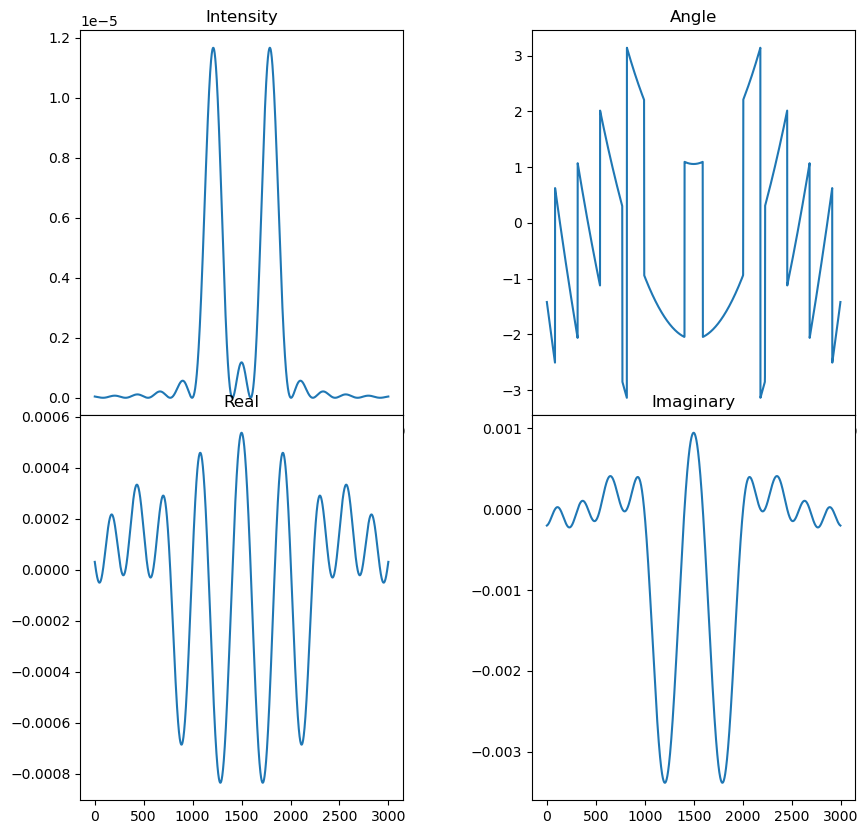

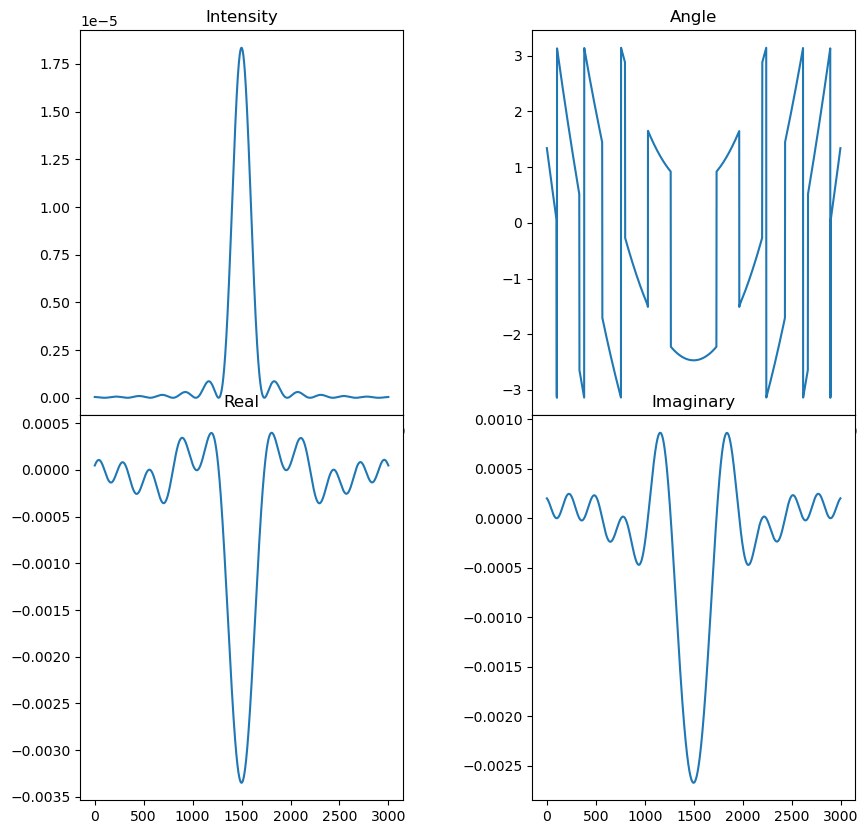

In [20]:
imaging_system.to('cpu')
test = imaging_system(torch.tensor(image_cls.double_slit(2.5*unit), dtype=torch.cfloat)).to('cuda')
plot_field(test)
plot_field(imaging_system(single_source))

# Pass Through lens

In [4]:
output_batches = []
batch_size = 100

for i in range(0, double_source.shape[0], batch_size):
    batch_input = double_source[i: i+batch_size].to('cuda')
    batch_input.to('cuda')
    imaging_system.to('cuda')
    batch_output = imaging_system(batch_input)
    output_batches.append(batch_output)
    
double_slits = torch.cat(output_batches, dim=0).squeeze()

single_source.to('cpu')
imaging_system.to('cpu')
single_slit = imaging_system(single_source)

# Load Dataset for training

In [78]:
from torch.utils.data import DataLoader, random_split

single_slits = single_slit.repeat(3000,1).to('cuda')

# Normalise intensity
input_intensity = 1000
double_slits = normalise_img_int(double_slits, pixel_size, input_intensity)
single_slits = normalise_img_int(single_slits, pixel_size, input_intensity)

# add noise
total_noise = 0
double_slits = add_guassian(double_slits, total_noise)
single_slits = add_guassian(single_slits, total_noise)

images = double_slits
labels = separations

dataset = CustomUnlabeledDataset(images, labels)
dataset = DataLoader(dataset, shuffle=True)

train_set, val_set = random_split(dataset.dataset, [27000, 3000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=30, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=30, shuffle=False)

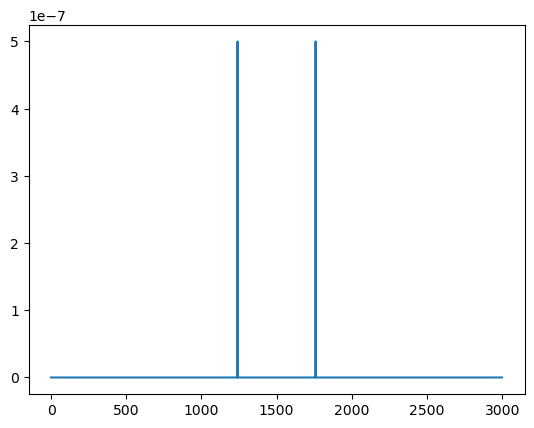

In [45]:
plt.plot(image[1])

In [6]:
# Dataset for classification

#15000 single img and 15000 double img needed for clsf 
single_slits_clsf = single_slit.repeat(15000,1)
single_slits_clsf = normalise_img_int(single_slits_clsf, pixel_size, input_intensity)

image_clsf = torch.cat((double_slits[:15000].to(device), single_slits_clsf.to(device)), dim=0)
labels_clsf = torch.cat((torch.ones(15000), torch.zeros(15000)), dim=0)

dataset_clsf = CustomUnlabeledDataset(image_clsf, labels_clsf)
dataset_clsf = DataLoader(dataset_clsf, shuffle=True)

train_set_clsf, val_set_clsf = random_split(dataset_clsf.dataset, [27000, 3000])

train_loader_clsf = torch.utils.data.DataLoader(train_set_clsf, batch_size=30, shuffle=True)
val_loader_clsf = torch.utils.data.DataLoader(val_set_clsf, batch_size=30, shuffle=False)

# Define model

In [7]:
from LinearNN import Linear

network_dimensions = [3000, 10000, 10000, 10000, 3000]
pixel_size = 1e-6
wavelength = 700e-9
layer_distance = 0.1
samples_per_pixel = 1
backend = "riemann"
device='cuda'

# Define the model
diffml_model = diffml.DONN(network_dimensions, pixel_size, wavelength, layer_distance, 
                           samples_per_pixel, backend, phase_modulation_init='constant')
diffml_model.to(device)

DONN(
  (layers): Sequential(
    (0): InitialLayer(
      (light_propagation): LightPropagation(
        (backend): RiemannBackend()
      )
    )
    (1): DiffractionLayer(
      (light_propagation): LightPropagation(
        (backend): RiemannBackend()
      )
    )
    (2): DiffractionLayer(
      (light_propagation): LightPropagation(
        (backend): RiemannBackend()
      )
    )
    (3): DiffractionLayer(
      (light_propagation): LightPropagation(
        (backend): RiemannBackend()
      )
    )
  )
)

In [89]:
# Define the linear model
import torch.nn as nn

class Linear_mix(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim

        self.layer_stack = nn.Sequential(
            *[nn.Linear(input_dim, 3000),
              nn.ReLU(),
              nn.Linear(3000, 3000),
              nn.ReLU(),
              nn.Linear(3000, 1),
              ]
        )

    def forward(self, x):
        x = self.layer_stack(x)
        return x


# Digital_NN_dim = [2000,2000,1]
digital_NN = Linear_mix(3000)

# Define Training Function

In [86]:
import torch.nn as nn

# output normalisation
Normalisation = 1e-2


def calc_output(diff_model, digital_model, data, noise=True):
    '''
    
    Calculate the outputs of the model during training and validation.
    '''
    
    diff_model.to(device)
    digital_model.to(device)
    data = data.squeeze() 
    data.to(device)
    
    # pass through diffNN
    output_field = diff_model(data).squeeze()    
    output_intensity = torch.abs(output_field)**2*pixel_size
    total_output_intensity = torch.sum(output_intensity, dim=1)
    
    
    # Apply Poisson noise to output of diffNN using reparametrization trick
    if noise:
        poisson_int = torch.poisson(output_intensity)
        noise = (poisson_int - output_intensity).detach().clone()
        output_intensity += noise

    # Pass through Digital NN
    output = digital_model(output_intensity).squeeze()
    output /= Normalisation
    return output, total_output_intensity, output_intensity

# Define training function

def train(diffml_model, digital_NN, noise, device, train_loader, optimizer_diff, optimizer_digital, epoch, tot_loss: list):
    diffml_model.train()
    digital_NN.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer_diff.zero_grad()
        optimizer_digital.zero_grad()
        
        output, total_output_intensity, _ = calc_output(diffml_model, digital_NN, data, noise)
        
        loss = nn.MSELoss()(output, target)
        loss.backward()
        
        optimizer_diff.step()
        optimizer_digital.step()
        if batch_idx % 100 == 0:
                print(f"Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)} ({100.0 * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                tot_loss.append(loss.item())
                
# Define validation function

def validate(diffml_model, digital_NN, device, val_loader):
    diffml_model.train()
    digital_NN.train()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output, output_intensity = calc_output(diffml_model, digital_NN, data)
            
            pred = (output > 0.5)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    accuracy = 100. * correct / total
    print(f"\nValidation set: Accuracy: {correct}/{total} ({accuracy:.0f}%)\n")
    return accuracy 

# Training for Classification

In [10]:
# Parameters for analysis
normalisation = 1e0 # Scale up the output intensity to make output of NN trainable

# Define a focusing diff_nn
focusing_model = diffml.DONN([500, 100], pixel_size, wavelength, layer_distance, 
                           samples_per_pixel, backend, phase_modulation_init='constant')

# Define the outputs used to train
def calc_output_clsf(model, data, normalisation, input_intensity_scaling):
    '''
    
    Calculate the outputs of the model during training and validation.
    '''
    
    data = data.squeeze() 
    data.to(device)
    focusing_model.to(device)
    
    output_field = focusing_model(model(data)).squeeze()  
    
    output_intensity = torch.sum(torch.abs(output_field)**2, dim=1)*pixel_size
    
    ratio = output_intensity/input_intensity_scaling
    output = nn.Tanh()(ratio/normalisation)
    return output, ratio, output_intensity

# Define training function

def train_clsf(model, device, train_loader, optimizer, epoch, input_intensity_scaling):
    model.train()
    model.to(device)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        output, ratio, output_intensity = calc_output_clsf(model, data, normalisation, input_intensity_scaling)
        
        loss = nn.BCELoss()(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
                print(f"Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)} ({100.0 * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

# Define validation function
def validate_clsf(model, device, val_loader, input_intensity_scaling):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output, ratio, output_intensity = calc_output_clsf(model, data, normalisation, input_intensity_scaling)

            pred = (output > 0.5)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    accuracy = 100. * correct / total
    print(f"\nValidation set: Accuracy: {correct}/{total} ({accuracy:.0f}%)\n")
    return accuracy     

# Print output to check for normalisation and scaling

In [90]:
for i, (data, target) in enumerate(val_loader):
    diffml_model.eval()
    digital_NN.eval()
    data, target = data.to(device), target.to(device)
    output, output_intensity,_ = calc_output(diffml_model, digital_NN, data)
    
    if i == 0:
        print('        label, ouput, output intensity:')
        print(torch.stack((target, output, output_intensity), dim=1))
        break

        label, ouput, output intensity:
tensor([[ 1.2647e+00,  7.4288e+00,  9.8471e+02],
        [ 1.6977e+00,  3.4261e+00,  9.9708e+02],
        [ 2.3065e+00,  9.5638e+00,  9.9905e+02],
        [ 2.4265e+00, -8.9426e+00,  9.9601e+02],
        [ 1.3333e+00,  7.3181e+00,  9.9131e+02],
        [ 3.4726e-01, -2.7107e+00,  9.8563e+02],
        [ 5.1446e-02,  6.2432e+00,  9.8976e+02],
        [ 1.9721e+00, -2.3217e+00,  9.8417e+02],
        [ 3.7298e-01,  4.1749e+00,  9.9905e+02],
        [ 2.0107e+00,  1.2665e+01,  9.8563e+02],
        [ 3.4726e-01,  3.7304e+00,  9.9914e+02],
        [ 8.8744e-01,  1.2733e+00,  9.9045e+02],
        [ 2.2893e+00, -3.2349e+00,  9.9241e+02],
        [ 2.5294e-01,  5.5331e+00,  9.8260e+02],
        [ 1.4834e+00,  1.5586e+00,  9.8028e+02],
        [ 4.7159e-02,  6.9533e+00,  9.9807e+02],
        [ 1.0718e+00,  1.3250e-01,  9.9123e+02],
        [ 1.8863e-01,  6.9078e+00,  9.7902e+02],
        [ 1.7449e+00,  2.9482e+00,  9.7604e+02],
        [ 1.7320e+00,  2.5861

In [93]:
# Check for classification
for i, (data, target) in enumerate(val_loader_clsf):
    diffml_model.eval()
    data, target = data.to(device), target.to(device)
    output, ratio, output_intensity = calc_output_clsf(diffml_model, data, normalisation, input_intensity)
    
    if i == 0:
        print('        label, output, ratio, output intensity:')
        print(torch.stack((target, output, ratio, output_intensity), dim=1))
        break

        label, output, ratio, output intensity:
tensor([[ 0.0000,  0.3857,  0.4067, 40.6702],
        [ 0.0000,  0.3857,  0.4067, 40.6702],
        [ 1.0000,  0.2653,  0.2718, 27.1836],
        [ 0.0000,  0.3857,  0.4067, 40.6702],
        [ 1.0000,  0.4763,  0.5182, 51.8203],
        [ 1.0000,  0.4715,  0.5120, 51.2018],
        [ 0.0000,  0.3857,  0.4067, 40.6702],
        [ 1.0000,  0.4875,  0.5327, 53.2747],
        [ 0.0000,  0.3857,  0.4067, 40.6702],
        [ 0.0000,  0.3857,  0.4067, 40.6702],
        [ 0.0000,  0.3857,  0.4067, 40.6702],
        [ 1.0000,  0.4605,  0.4979, 49.7947],
        [ 1.0000,  0.4859,  0.5307, 53.0686],
        [ 0.0000,  0.3857,  0.4067, 40.6702],
        [ 0.0000,  0.3857,  0.4067, 40.6702],
        [ 1.0000,  0.2781,  0.2856, 28.5581],
        [ 1.0000,  0.2941,  0.3030, 30.3022],
        [ 0.0000,  0.3857,  0.4067, 40.6702],
        [ 1.0000,  0.3993,  0.4228, 42.2832],
        [ 1.0000,  0.4761,  0.5180, 51.7977],
        [ 1.0000,  0.4935,  0.54

# Train Classification

In [31]:
import torch.optim as optim

noise = True
device = 'cuda'

# setup optimizer
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"

optimizer = optim.Adam(diffml_model.parameters(), lr=0.001)
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_clsf(diffml_model, device, train_loader_clsf, optimizer, epoch, input_intensity)
    validate_clsf(diffml_model, device, val_loader_clsf, input_intensity)

print("Training complete!")

NameError: name 'train_clsf' is not defined

# Train

In [91]:
import torch.optim as optim

noise = False
device = 'cuda'

# setup optimizer
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"

#torch.autograd.set_detect_anomaly(True)

optimizer1 = optim.Adam(diffml_model.parameters(), lr=0.00)
optimizer2 = optim.Adam(digital_NN.parameters(), lr=0.001)

num_epochs = 3
tot_loss = []
for epoch in range(1, num_epochs + 1):
    train(diffml_model,digital_NN, noise, device, train_loader, optimizer1, optimizer2, epoch, tot_loss)
    #validate(model, device, val_loader)

print("Training complete!")

Train Epoch: 1 [0/27000 (0%)]	Loss: 12.936023
Train Epoch: 1 [3000/27000 (11%)]	Loss: 2.918342
Train Epoch: 1 [6000/27000 (22%)]	Loss: 0.954607
Train Epoch: 1 [9000/27000 (33%)]	Loss: 4.590030
Train Epoch: 1 [12000/27000 (44%)]	Loss: 0.694982
Train Epoch: 1 [15000/27000 (56%)]	Loss: 4.947988
Train Epoch: 1 [18000/27000 (67%)]	Loss: 0.658685
Train Epoch: 1 [21000/27000 (78%)]	Loss: 3.979647
Train Epoch: 1 [24000/27000 (89%)]	Loss: 1.282873
Train Epoch: 2 [0/27000 (0%)]	Loss: 1.046128
Train Epoch: 2 [3000/27000 (11%)]	Loss: 0.519742
Train Epoch: 2 [6000/27000 (22%)]	Loss: 0.977298
Train Epoch: 2 [9000/27000 (33%)]	Loss: 0.590101
Train Epoch: 2 [12000/27000 (44%)]	Loss: 0.758150
Train Epoch: 2 [15000/27000 (56%)]	Loss: 1.665873
Train Epoch: 2 [18000/27000 (67%)]	Loss: 0.705392
Train Epoch: 2 [21000/27000 (78%)]	Loss: 0.506145
Train Epoch: 2 [24000/27000 (89%)]	Loss: 0.999594
Train Epoch: 3 [0/27000 (0%)]	Loss: 0.637221
Train Epoch: 3 [3000/27000 (11%)]	Loss: 0.576105
Train Epoch: 3 [6000/

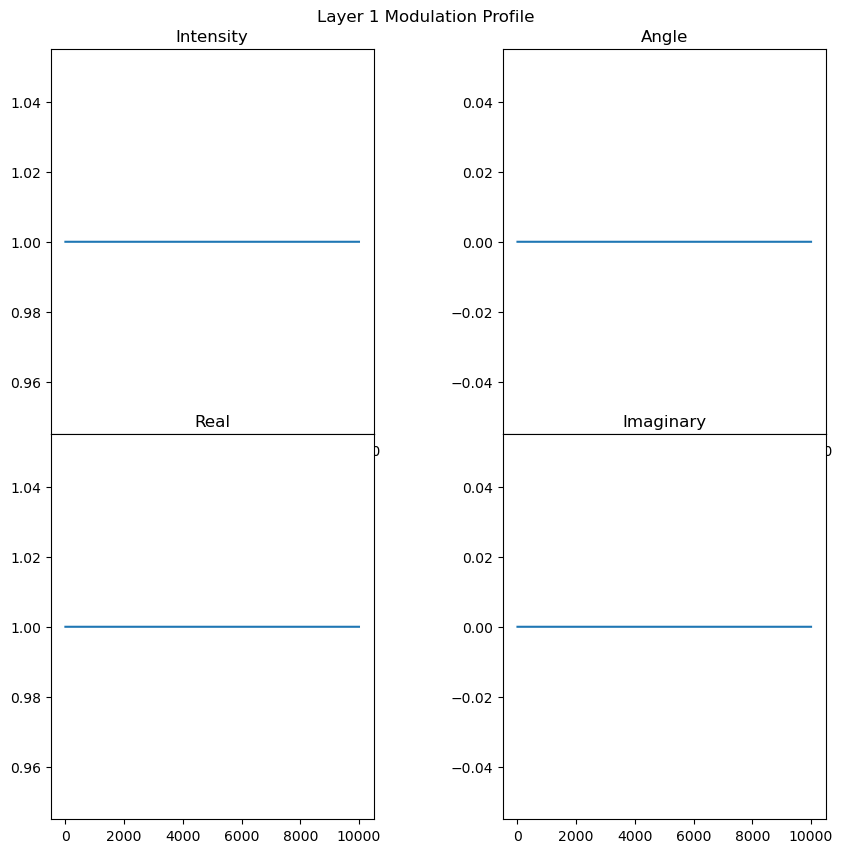

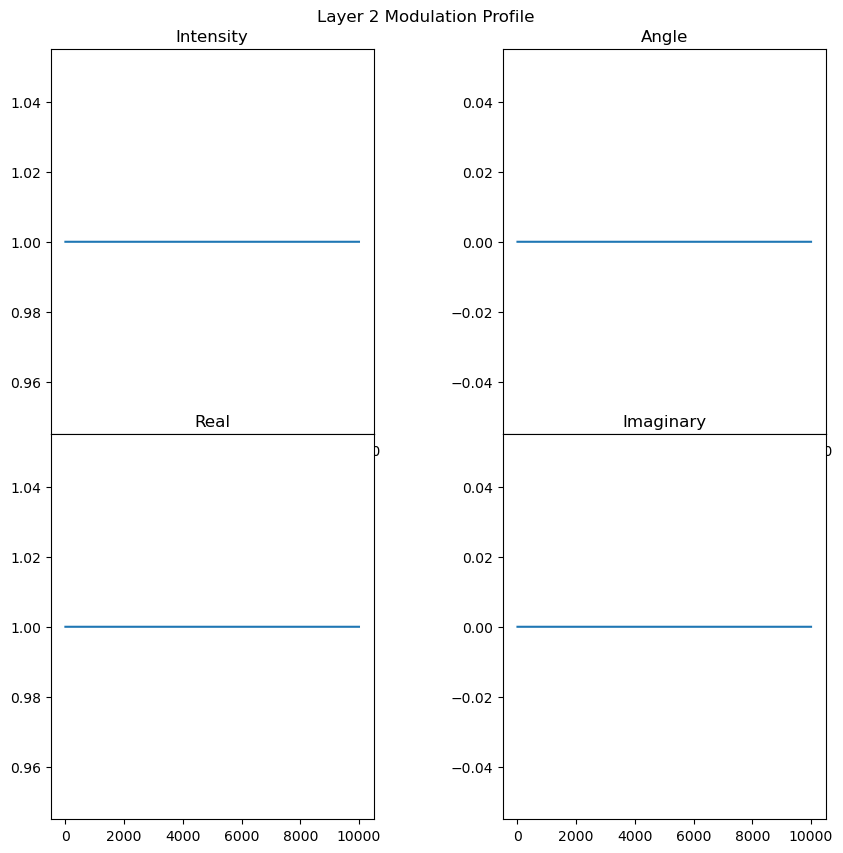

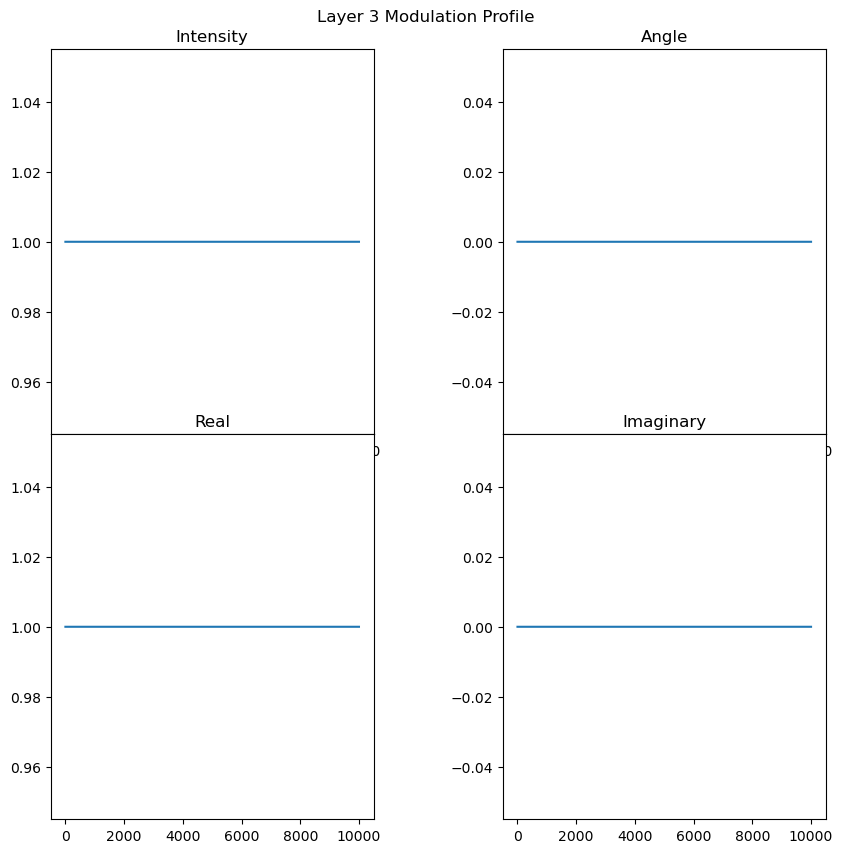

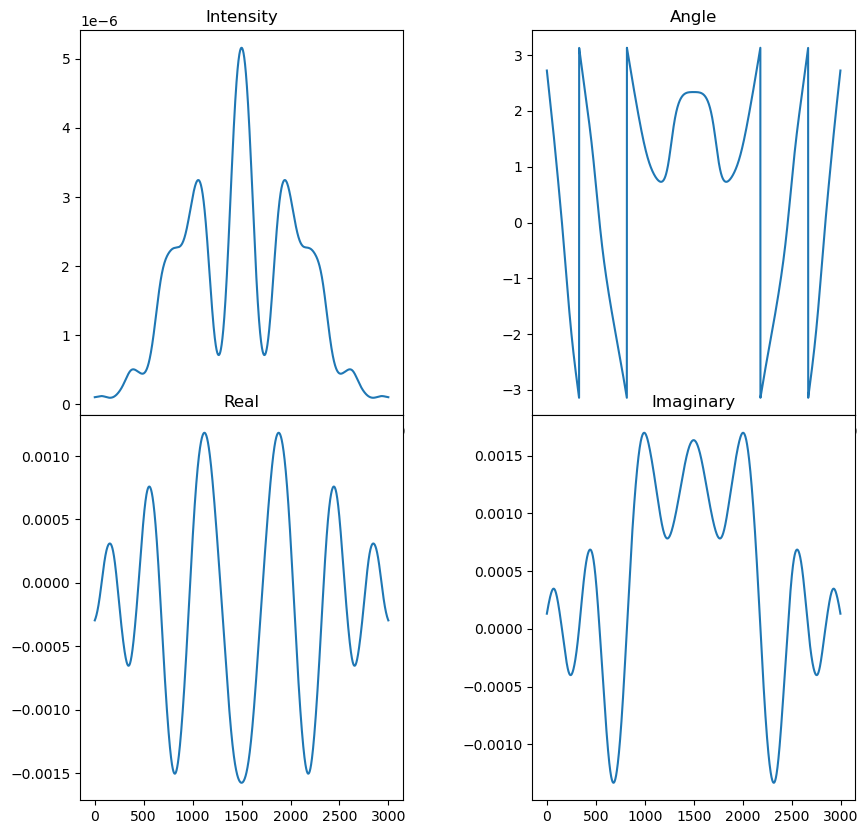

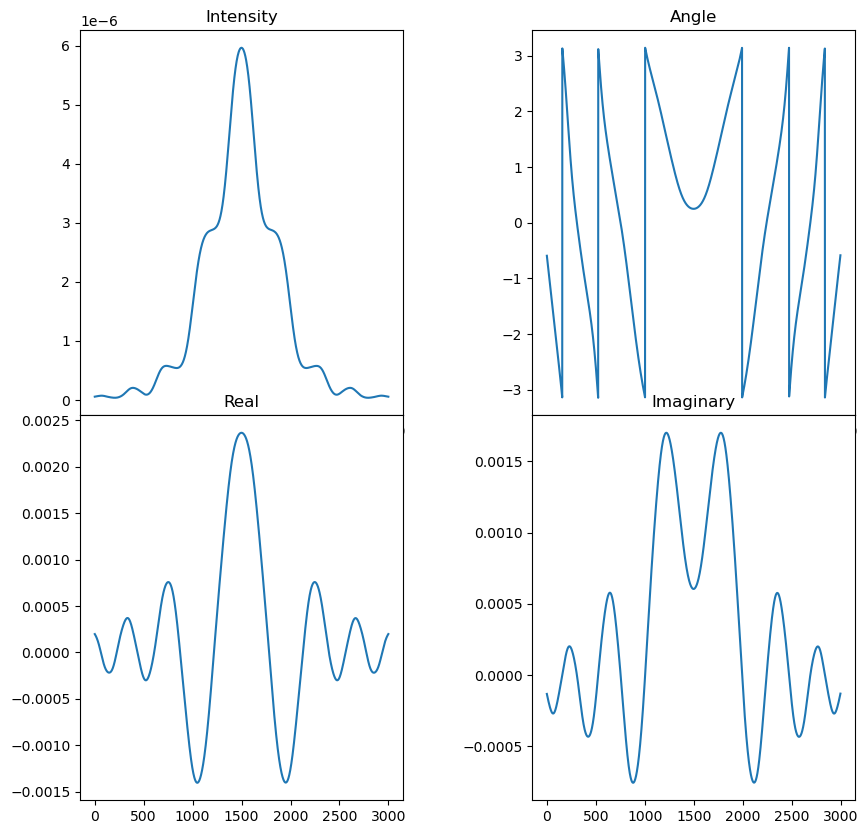

In [22]:
diffml.plot_system_layers(diffml_model)

diffml_model.eval()
diffml_model.to('cuda')

test = imaging_system(torch.tensor(image_cls.double_slit(2.5*unit), dtype=torch.cfloat)).to('cuda')
test.to('cuda')
output_test = diffml_model(test)
plot_field(output_test)

single_slit.to('cuda')
output_single = diffml_model(single_slit.to('cuda'))
plot_field(output_single)

In [75]:
import matplotlib.pyplot as plt

cumu_out = []
cumu_sep = []
cumu_int = [] 

output_image = []
device = 'cpu'
for i, (data, target) in enumerate(val_loader):
    diffml_model.eval()
    digital_NN.eval()
    data, target = data.to('cpu'), target.to('cpu')
    output, output_intensity, image = calc_output(diffml_model, digital_NN, data, noise=False)
    
    cumu_out.append(output.detach().numpy())
    cumu_sep.append(target.numpy())
    cumu_int.append(output_intensity.detach().numpy())
    output_image.append(image.detach().numpy())
    
cumu_out = np.array(cumu_out).flatten()
cumu_sep = np.array(cumu_sep).flatten()
cumu_int = np.array(cumu_int).flatten()


In [36]:
bias = cumu_out-cumu_sep

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

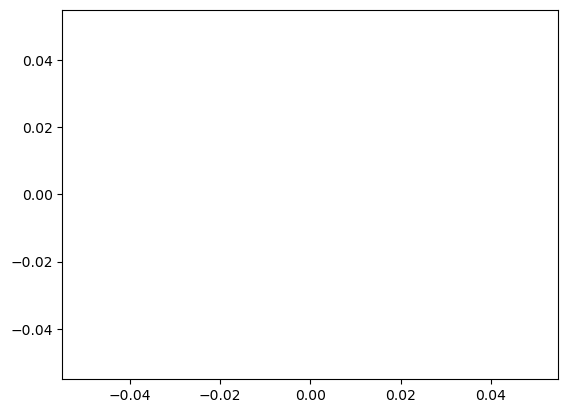

In [37]:

plt.plot()

output_image[1][6]

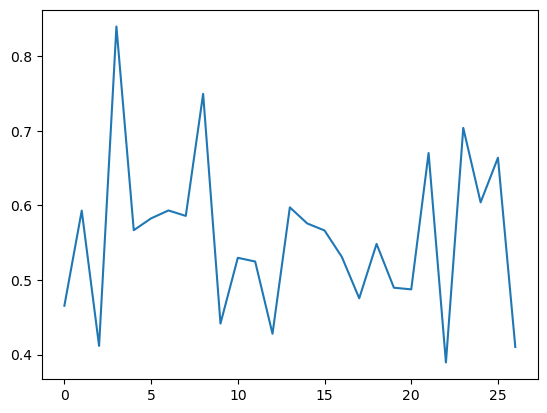

In [38]:
plt.plot(tot_loss)
#plt.yscale('log')

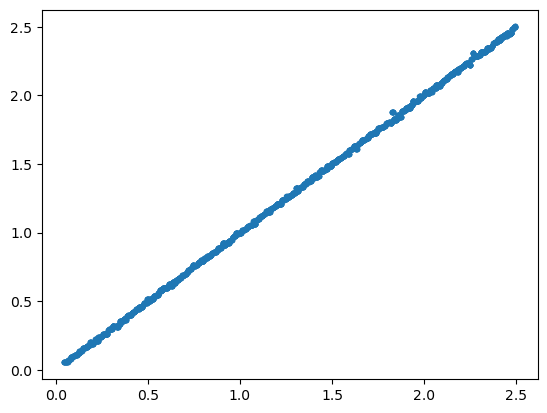

In [76]:
plt.scatter(cumu_sep, cumu_out, marker = '.')

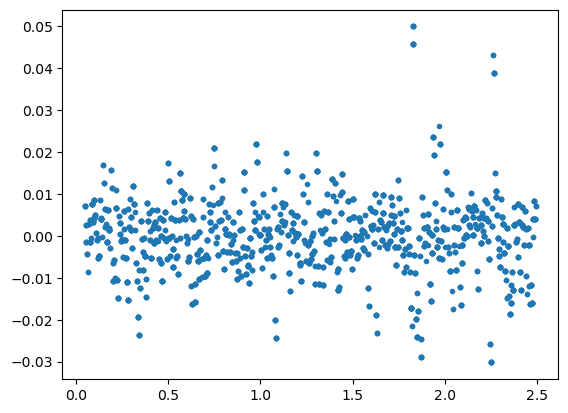

In [77]:
plt.scatter(cumu_sep, cumu_out-cumu_sep, marker = '.')

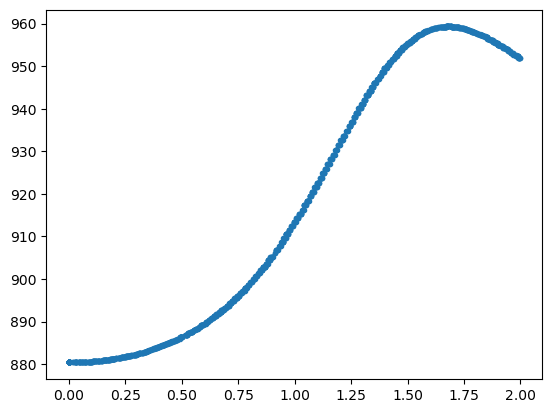

In [157]:
plt.scatter(cumu_sep, cumu_int, marker = '.')